# Visualizing the effect of different coordinate inputs

In this notebook, we will use different coordinates as input and visualize the effect this has on the resulting image.
We will show the standard (x,y) coordinate and then explore from there.

In [104]:
# reload imports so if you change stuff in models/cppn.py it'll update the notebook periodically to see it.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append('/Users/Heysoos/Documents/Pycharm Projects/Dissertation/01_CPPN')
from models.cppn import CPPN, Sampler, multiscale_targets_apply

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from copy import deepcopy

import matplotlib.pyplot as plt
import imageio
from PIL import Image
from datetime import datetime
from tqdm import tqdm

from IPython.display import display, clear_output
import time

C:\Users\Heysoos\anaconda3\envs\torchstuff\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utility functions

In [81]:
def crop_to_square_and_resize(img, new_width_height):
    # Get the dimensions of the image
    width, height = img.size

    # Determine the size of the square
    new_size = min(width, height)

    # Calculate the left, top, right, and bottom coordinates for the crop
    left = (width - new_size) / 2
    top = (height - new_size) / 2
    right = (width + new_size) / 2
    bottom = (height + new_size) / 2

    # Crop the image to a square
    img_cropped = img.crop((left, top, right, bottom))
    # Resize
    img_resized = img_cropped.resize(new_width_height)

    return img_resized

Let's set up a basic architecture that we know usually makes some nice images.

In [65]:
net_size = [128, 128, 128, 64, 32, 2]
dim_z = 16
dim_c = 3


# Fourier Features settings
# proj_dims = [int(3)]
proj_dims = [128]
proj_scales = [2. for i in proj_dims]
projection_config = (proj_dims, proj_scales)
print(net_size)

[128, 128, 128, 64, 32, 2]



# Generate an Example Image

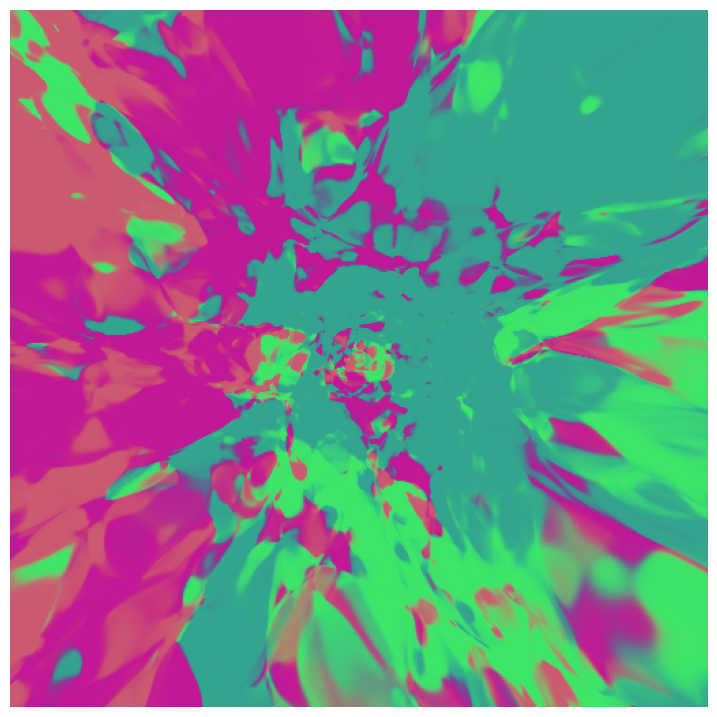

In [74]:
cppn = CPPN(net_size, dim_z, dim_c, projection_config=projection_config).cuda()
sampler = Sampler(cppn)
cppn.reinit(empty_cache=True)

gscale = 1
scale = 2.
xres = 512
yres = int(512*1 )
zscale = 1.
nscale = 0

z =  torch.randn(1, dim_z).cuda()
delta_v = torch.randn(1, dim_z).cuda() 
# delta_v = delta_v / torch.norm(delta_v)
z2 = z + 0.02*delta_v
coords = cppn._coordinates(scale*gscale,
                           xres, yres, z*zscale*gscale)

# coords[2] = coords[2] * 0.

x = sampler.generate_img(cppn, z*zscale, scale, xres, yres, coords=coords)
sampler.imshow((x * 255).astype(np.uint8))

Now let's make some images with different coordinates, save the outputs and coordinates, and then plot it all together below.
The key variable we want to change is the `coords` variable which contains our input coordinates. Normally it contains $(x, y, r)$ along with a few empty null coordinates that we can use to input other stuff, but we'll ignore for now.

Let's make a set of coordinates which we can then use to iterate over. I want the following coords:
- $(x, y)$
- $(|x|, |y|)$
- $(r)$
- (sin($x$), cos($x$))
- Random Fourier projections
- $(x, y, r, \text{image})$

Let's load an image first of our favourite pug.

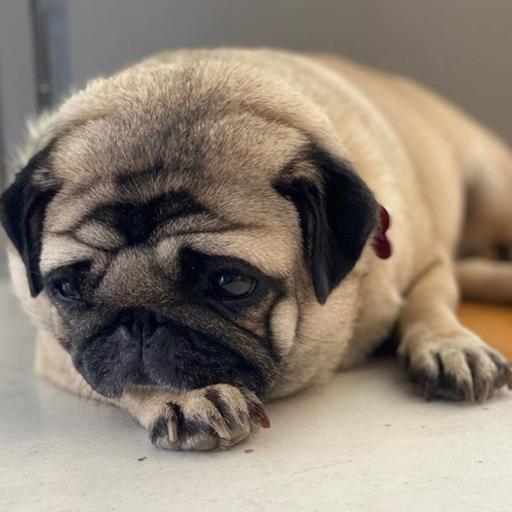

In [121]:
target_file = '../targets/pug.png'
img = crop_to_square_and_resize(Image.open(target_file), (yres, xres))
img_mean = np.mean(img)
img_std = np.std(img)
norm_img = 0.33 * ((img - img_mean) / img_std).sum(axis=-1)
input_img = torch.cuda.FloatTensor(norm_img)
img

In [122]:
coords = cppn._coordinates(scale*gscale,
                           xres, yres, z*zscale*gscale)

coord_xy = deepcopy(coords)
coord_xy[2:-2] = [c*0. for c in coord_xy[2:-2] ]

coord_abs_xy = deepcopy(coords)
coord_abs_xy[2:-2] = [c*0. for c in coord_abs_xy[2:-2] ]
coord_abs_xy[:2] = [c.abs() for c in coord_abs_xy[:2]]

coord_r = deepcopy(coords)
coord_r[:2] = [c*0. for c in coord_r[:2]]

coord_sincos = deepcopy(coords)
coord_sincos[2:-2] = [c*0. for c in coord_sincos[2:-2] ]
coord_sincos[0] = torch.cos(np.pi*coord_sincos[0])
coord_sincos[1] = torch.cos(np.pi*coord_sincos[1])

coord_ginger = deepcopy(coords)
coord_ginger[3] = input_img.reshape(1, -1, 1)

figure_coords = [ coord_xy,
                  coord_abs_xy,
                  coord_r,
                  coord_sincos,
                  coord_xy, # we use the same coords as coord_xy but it gets "Fourier Featured".
                  coord_ginger
                  ]

coord_labels = [r'$(x, y)$',
                r'$(|x|, |y|)$',
                r'$(r)$',
                r'$( \cos(x), \cos(y))$',
                r'$ FF(x, y)$',
                r'$(x, y, r,$img$)$'
                ]


Make a loop that generates images with a number of different coordinates for the same model, for a number of different models.

In [123]:
num_models = 5

figure_imgs = []
for i_m in range(num_models):
    # reinit the model
    cppn.reinit(empty_cache=True)
    model_imgs = []
    for i_c in range(len(figure_coords)):          
        # make images for each coord
        
        # make fourier features of the second-last coord
        if i_c == len(figure_coords) - 2:
            cppn.use_fourier_features = True
        else:
            cppn.use_fourier_features = False
        with torch.no_grad():
            x = sampler.generate_img(cppn, z*zscale, scale, xres, yres, coords=figure_coords[i_c])
        
        model_imgs.append(x)
    figure_imgs.append(model_imgs)

# Settings up the figures

In [150]:
# graphical properties
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['pdf.fonttype'] = 42 # prepare as vector graphic
plt.rcParams['ps.fonttype'] = 42

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 10
})

cm = 1/2.54  # centimeters in inches

# size of full-width figures:
#fig = plt.figure(figsize=(18*cm, xx*cm))

# size of half-width figures:
#fig = plt.figure(figsize=(9*cm, 12.4*cm))

C:\Users\Heysoos\AppData\Local\Temp\ipykernel_11772\661642645.py:48: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


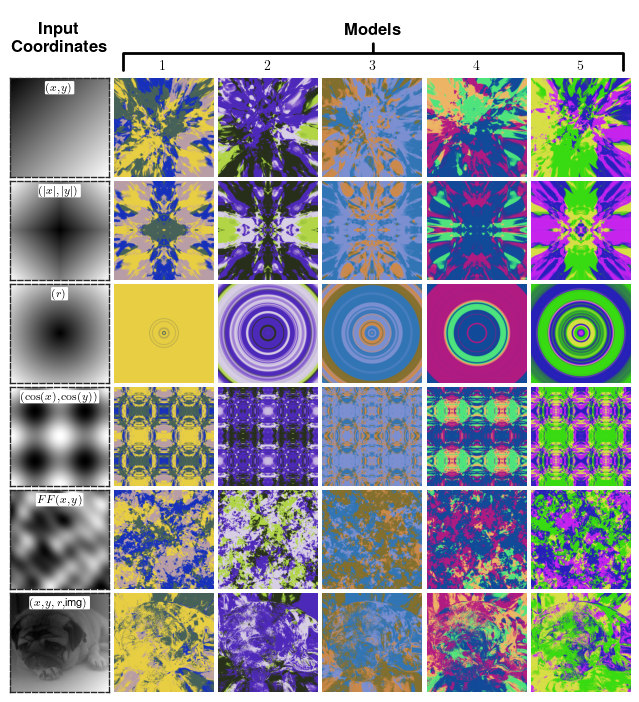

In [223]:
N = num_models + 1
M = len(figure_coords)

fig, axes = plt.subplots(nrows=M, ncols=N, figsize=(8, 8))

# If only one row or column, axes is not a 2D array
if N == 1 or M == 1:
    axes = np.array(axes).reshape(M, N)

# Loop through the grid and display images
for i in range(M): #rows
    for j in range(N): #columns
        ax = axes[i, j]
        
        # plot input coordinates
        if j == 0:
            if i == M - 2: # this is the fourier feature coordinates which needs special care
                with torch.no_grad():
                    fig_coord = cppn.fourier_features(coord_xy).reshape(yres, xres, 128).sum(dim=-1).cpu().numpy()
            else:
                fig_coord = torch.stack(figure_coords[i][:-1]).sum(dim=0).reshape(xres, yres).cpu().numpy()
            ax.imshow(fig_coord, cmap='gray')
            # if i ==0:
                # ax.set_title(f'Input Coordinates')
            # ax.set_title(coord_labels[i], fontsize=10) 
            fig.text(0.5, 0.9, coord_labels[i], 
                         transform=ax.transAxes, ha='center', va='center', fontsize=8,
                         bbox=dict(boxstyle='round,pad=0.1', facecolor='white', linewidth=0))
            
            ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
            for spine in ax.spines.values():
                spine.set_edgecolor('#262626')
                spine.set_linewidth(1)
                spine.set_linestyle('--')
        
        # plot generated image
        else:
            if i == 0:
                ax.set_title(fr'${j}$', fontsize=10)
            ax.imshow(figure_imgs[j - 1][i])
            ax.axis('off')  # Turn off axis

fig.text(0.5, 1.4, r'\textbf{Input}' + '\n' + r'\textbf{Coordinates}', transform=axes[0, 0].transAxes, ha='center', va='center', fontsize=12)
model_mid_x = 1/N + (N-1)/N/2
plt.annotate(r'\textbf{Models}', xy=(model_mid_x, 0.92), xytext=(model_mid_x, 0.945), xycoords='subfigure fraction',
            fontsize=12, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=15.0, lengthB=1.', lw=1.0, color='k'))
plt.tight_layout()

plt.subplots_adjust(wspace=0.05, hspace=0.02) 
# plt.savefig('../figures/cppn_coordinates_new.pdf', bbox_inches='tight')

plt.show()